# Variational Monte Carlo

In this numerical project I am applying the variational Monte Carlo (VMC) method to the 1D quantum harmonic oscillator, after which I am using VMC to study the ground-state of the $^4$He for a spin/isospin independent interaction.

According to the variational principle, given a hamiltonian $H$ and a trial wave function $\Psi$, the upper bound to the energy of the ground state of $H$ is calculated as

\begin{equation}
\langle H \rangle = \frac{\int{\Psi^*H\Psi}}{\int{|\Psi|^2}}
\end{equation}

To calculate $\langle H \rangle$, the maltivariate pdf $f(\vec{R})$ and the local energy $E_L$ are introduced:

\begin{equation}
f(\vec{R}) = \frac{|\Psi(\vec{R})|^2}{\int{d\vec{R} |\Psi(\vec{R})|^2}}
\end{equation}

\begin{equation}
E_L(\vec{R}) = \frac{H\Psi(\vec{R})}{\Psi(\vec{R})}
\end{equation}

Finally, the following integral has to be evaluated:

\begin{equation}
\langle H \rangle = \int{d\vec{R} f(\vec{R}) E_L(\vec{R})}
\end{equation}

### The Harmonic Oscillator

The one-dimentional harmonic oscillator is defined by the Hamiltonian $H = -\frac{d^2}{dx^2} + x^2$ and has the exact ground state wave function $\Psi_0(x) = \frac{1}{\pi^{1/4}}e^{-x^2/2}$. In the example below, a similar wavefunction, with the variational parameter $\alpha$, is used:

\begin{equation}
\Psi(x) = \frac{\sqrt{\alpha}}{\pi^{1/4}}e^{-\alpha^2 x^2/2}
\end{equation}

Then,
\begin{equation}
E_L(x) = \frac{H\Psi}{\Psi} = \alpha^2 + x^2(1-\alpha^4)
\end{equation}

and the following integral results in the upper bound for the ground state energy:

\begin{equation}
E_V = \int_{-\infty}^{+\infty}{dx |\Psi|^2 E_L(x)}
\end{equation}

In [ ]:
%matplotlib inline
import numpy as np
from numpy import pi, exp, sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.optimize import minimize

n = 10000   #The number of samples

def QHO_energy(alpha):
  random.seed(12231)
  e = 0; elocal = 0; e2 = 0

  for i in range(0, n):
    x = random.gauss(0, 1)/(sqrt(2)*alpha)
    elocal = alpha**2 + x**2*(1 - alpha**4)
    e = e + elocal
    e2 = e2 + elocal**2

  return e, e2    #Returns the accumulated local energies and variances squared

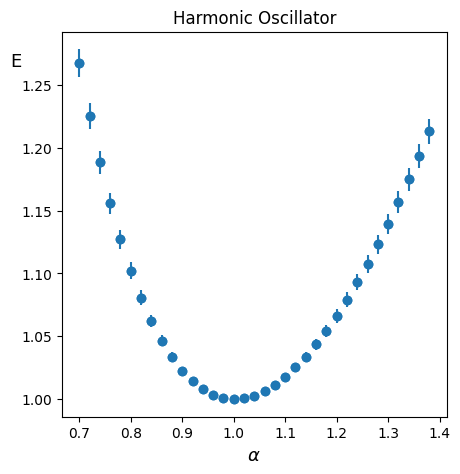

As an example, taken alpha = 0.5 results in g.s. E < 2.13 +/- 0.03


In [ ]:
#Plotting the results w.r.t. the variational parameter
energies = np.empty(shape = (0, 3))
alpha_min = 0.7; alpha_max = 1.4

for alpha in np.arange(alpha_min, alpha_max, 0.02):
  QHO_energy(alpha)
  e_QHO = QHO_energy(alpha)[0]
  e2_QHO = QHO_energy(alpha)[1]
  energies = np.append(energies, [[alpha, (e_QHO/n), sqrt((e2_QHO/n - (e_QHO/n)**2)/n)]], axis = 0)

fig, (indep) = plt.subplots(1, 1, figsize=(5,5))

scatter = indep.scatter(energies[:, 0], energies[:, 1])
indep.errorbar(energies[:, 0], energies[:, 1], yerr = energies[:, 2], fmt = 'o')
indep.set_title('Harmonic Oscillator')
indep.set_xlabel('$\\alpha$', fontsize=13)
indep.set_ylabel('E', fontsize=13, rotation='horizontal', y = 0.9)
indep.set(box_aspect = 1)

plt.subplots_adjust(wspace=0.5 )
plt.show()

alpha = 0.5
print('As an example, taken alpha =', alpha, 'results in g.s. E <', '%.2f' % (QHO_energy(alpha)[0]/n), '+/-', '%.2f' % sqrt((QHO_energy(alpha)[1]/n - (QHO_energy(alpha)[0]/n)**2)/n))

The exact upper bound to the energy corresponding to the parameter $\alpha = 0.5$ is $E = 2.125$ with the variance $\sigma = 2.6516$. The plot above demonstrates how the estimated energy values depend on the choice of the variational parameter. It is worth mentioning, that choosing $\alpha = 1$ would result in the exact solution to the problem, to find which one needs to vary the energy w.r.t. the variational parameter $\alpha$.

### The $^4$He Nucleus with a Spin/Isospin Independent Interaction

The system is described by the following centrtal potential:

\begin{equation}
V(r) = 1000e^{-3r^2} - 163.35e^{-1.05r^2} - 83e^{-0.8r^2} - 21.5e^{-0.6r^2} - 11.5e^{-0.4r^2}
\end{equation}

Here $V$ is given in $MeV$ and the internuclear distances should be measured in $fm$.

A trial wave function can take the following (translationally invariant) form:
\begin{equation}
\Psi(\vec{r}_1,...,\vec{r}_4) = \prod_{i<j}^{4}f(r_{ij})e^{-\gamma\sum_{k<l}(\vec{r}_k-\vec{r}_l)}
\end{equation}

where the correlation is

\begin{equation}
f(r_{ij}) = e^{-\gamma r^2} + ae^{-(\beta + \gamma)r^2}
\end{equation}

Overall, there are three variational parameters: $a$, $\beta$, and $\gamma$.

In [ ]:
NA = 4
r = np.empty([NA, 3])
rp = np.empty([NA, 3])
rm = np.empty([NA, 3])

#This function returns the wave function to be used in the calculations.

def wf(x, r): #The trial wave function

  def f(x, r2): #Correlation
    return exp(-x[2]*r2) + x[0]*exp(-([x[1]]+x[2])*r2)  #Parameters: x[0] is a, x[1] is b, x[2] is g

  wf = 1
  for i in range(0, NA - 1):
    for j in range(i + 1, NA):
      r2 = (r[i,0] - r[j,0])**2 + (r[i,1] - r[j,1])**2 + (r[i,2] - r[j,2])**2
      wf = wf*f(x, r2)

  return wf

In [ ]:
#This function computes the local energy to be used in the VMC.

def elocal(x, *args):
  wfold, r = args
  h2div2m = 20.74 #MeV*fm^2
  h = 0.001

  def V(r2):    #Potential
    return 1000*exp(-3*r2) - 163.35*exp(-1.05*r2) - 83*exp(-0.8*r2) - 21.5*exp(-0.6*r2) - 11.5*exp(-0.4*r2)

  for i in range(0, NA):
    for k in range(0, 3):
      rp[i,k] = r[i,k]
      rm[i,k] = r[i,k]

  ekin = 0

  for i in range(0, NA):    #Second derivatives as centered second differences
    for k in range(0, 3):
      rp[i,k] = r[i,k] + h
      rm[i,k] = r[i,k] - h
      wfplus = wf(x, rp)
      wfminus = wf(x, rm)
      ekin = ekin + (wfplus + wfminus - 2*wfold)/h**2
      rp[i,k] = r[i,k]
      rm[i,k] = r[i,k]

  epot = 0

  for i in range(0, NA - 1):
    for j in range(i + 1, NA):
      r2 = (r[i,0] - r[j,0])**2 + (r[i,1] - r[j,1])**2 + (r[i,2] - r[j,2])**2
      epot = epot + V(r2)

  eloc = -h2div2m/wfold*ekin + epot

  return eloc

In [ ]:
#This function computes the upper bound of the g.s. energy as a function of
#the variational parameters. It is later minimized w.r.t. them.

def VMC_He(x):

  random.seed(12231)
  nmoves = 1000
  ntherm = 10
  sume = 0
  nacceptances = 0
  step = 1

  for i in range(0, NA):    #Determine the initial point (start the walker)
    for j in range(0, 3):
      r[i, j] = 10*step*(random.uniform(0, 1) - 0.5)

  wfold = wf(x, r)     #Call the wavefunction at the initial point

  for imoves in range(0, nmoves):     #The loop of moves starts

    for itherm in range(0, ntherm):     #Thermalization loop starts
      for i in range(0, NA):
        for j in range(0, 3):
          rp[i, j] = r[i, j] + step*(random.uniform(0, 1) - 0.5)   #Attempt a move
      wfnew = wf(x, rp)                                            #Compute new wavefunction

      if (wfnew/wfold)**2 > random.uniform(0, 1):   #The Metropolis question: accept the move if true
        nacceptances = nacceptances + 1
        for i in range(0, NA):        #Update the walker
          for k in range(0, 3):
            r[i,k] = rp[i,k]
        wfold = wfnew                 #Update the wavefunction
                                      #Thermalization loop ends
    energy = elocal(x, wfold, r)      #Sample the energy
    sume = sume + energy              #The loop of moves ends

  e = sume
  return e

guess = np.array([-1, 2, 0.1])
bounds = ((-3,3), (-3,3), (0,3))
results = minimize(VMC_He, guess, bounds = bounds, method = 'COBYLA', options = {'tol': 1e-6, 'disp': True})

In [ ]:
#This function computes the upper bound of the g.s. energy, provided
#the variational parameters. It also records the positions of the particles
#in the intermediate steps and plots them.

def VMC_He_plot(x):

  random.seed(12231)

  first0 = np.empty(shape = (0, 2))           #Stores the first 20 moves of particle 0 with thermalization, ref. to the CM frame
  first1 = np.empty(shape = (0, 2))
  first2 = np.empty(shape = (0, 2))
  first3 = np.empty(shape = (0, 2))
  moves = np.empty(shape = (0, 3))            #Stores the moves of 1 particle, after 1000 moves, with thermolization, ref. to the CM frame
  movesnotherm = np.empty(shape = (0, 3))     #Stores the moves of 1 particle, after 1000 moves, with NO thermolization, ref. to the CM frame
  movext0 = np.empty(shape = (0, 3))          #Stores the moves of 1 particle, after 1000 moves, with thermalization, ref. to an external origin
  movext1 = np.empty(shape = (0, 3))
  movext2 = np.empty(shape = (0, 3))
  movext3 = np.empty(shape = (0, 3))

  nmoves = 1000
  ntherm = 10
  sume = 0
  sume2 = 0
  nacceptances = 0
  step = 1

  for i in range(0, NA):
    for j in range(0, 3):
      r[i, j] = 10*step*(random.uniform(0, 1) - 0.5)


  wfold = wf(x, r)

  for imoves in range(0, nmoves):

    for itherm in range(0, ntherm):
      for i in range(0, NA):
        for j in range(0, 3):
          rp[i, j] = r[i, j] + step*(random.uniform(0, 1) - 0.5)
      wfnew = wf(x, rp)

      if len(movesnotherm) < 1000:    #To store the first 1000 moves of one particle without thermalization
        movesnotherm = np.append(movesnotherm, [[(rp[0,0] - (rp[0,0] + rp[1,0] + rp[2,0] + rp[3,0])/4),
                                                  (rp[0,1] - (rp[0,1] + rp[1,1] + rp[2,1] + rp[3,1])/4),
                                                  (rp[0,2] - (rp[0,2] + rp[1,2] + rp[2,2] + rp[3,2])/4)]], axis = 0)

      if (wfnew/wfold)**2 > random.uniform(0, 1):
        nacceptances = nacceptances + 1
        for i in range(0, NA):
          for k in range(0, 3):
            r[i,k] = rp[i,k]
        wfold = wfnew

    movext0 = np.append(movext0, [[r[0,0], r[0,1], r[0,2]]], axis = 0)
    movext1 = np.append(movext1, [[r[1,0], r[1,1], r[1,2]]], axis = 0)
    movext2 = np.append(movext2, [[r[2,0], r[2,1], r[2,2]]], axis = 0)
    movext3 = np.append(movext3, [[r[3,0], r[3,1], r[3,2]]], axis = 0)

    moves = np.append(moves, [[(r[0,0] - (r[0,0] + r[1,0] + r[2,0] + r[3,0])/4), (r[0,1] - (r[0,1] + r[1,1] + r[2,1] + r[3,1])/4), (r[0,2] - (r[0,2] + r[1,2] + r[2,2] + r[3,2])/4)]], axis = 0)

    if imoves < 20: #Append data for fig1
      first0 = np.append(first0, [[(r[0,0] - (r[0,0] + r[1,0] + r[2,0] + r[3,0])/4), (r[0,1] - (r[0,1] + r[1,1] + r[2,1] + r[3,1])/4)]], axis = 0)
      first1 = np.append(first1, [[(r[1,0] - (r[0,0] + r[1,0] + r[2,0] + r[3,0])/4), (r[1,1] - (r[0,1] + r[1,1] + r[2,1] + r[3,1])/4)]], axis = 0)
      first2 = np.append(first2, [[(r[2,0] - (r[0,0] + r[1,0] + r[2,0] + r[3,0])/4), (r[2,1] - (r[0,1] + r[1,1] + r[2,1] + r[3,1])/4)]], axis = 0)
      first3 = np.append(first3, [[(r[3,0] - (r[0,0] + r[1,0] + r[2,0] + r[3,0])/4), (r[3,1] - (r[0,1] + r[1,1] + r[2,1] + r[3,1])/4)]], axis = 0)

    energy = elocal(x, wfold, r).item()
    sume = sume + energy
    sume2 = sume2 + energy**2

  e = sume/nmoves
  e2 = sume2/nmoves

  print('Energy, MeV = ', '%.3f' % e)
  print('Error, MeV = ', '%.3f' % sqrt((e2 - e**2)/nmoves))
  print('Acceptance rate, % = ', 100*nacceptances/(nmoves*ntherm))

  fig, ([fig1, fig2], [fig3, fig4]) = plt.subplots(2, 2, figsize=(10, 10))

  plot1 = fig1.plot(first0[:, 0], first0[0:, 1], linewidth  = 0.5, c = 'C0')
  plot1 = fig1.plot(first1[:, 0], first1[0:, 1], linewidth  = 0.5, c = 'C0')
  plot1 = fig1.plot(first2[:, 0], first2[0:, 1], linewidth  = 0.5, c = 'C0')
  plot1 = fig1.plot(first3[:, 0], first3[0:, 1], linewidth  = 0.5, c = 'C0')
  fig1.axhline(0, color = 'black', linewidth = 1)
  fig1.axvline(0, color = 'black', linewidth = 1)
  fig1.set_xlim(-3, 3)
  fig1.set_ylim(-3, 3)
  fig1.set(box_aspect = 1)
  fig1.text(0.9, 0.9, '(a)', fontsize = 11, horizontalalignment='center', verticalalignment='center', transform = fig1.transAxes)

  plot2 = fig2.scatter(moves[:, 0], moves[:, 1], s = 0.5)
  fig2.axhline(0, color = 'black', linewidth = 1)
  fig2.axvline(0, color = 'black', linewidth = 1)
  fig2.set_xlim(-3, 3)
  fig2.set_ylim(-3, 3)
  fig2.set(box_aspect = 1)
  fig2.text(0.9, 0.9, '(b)', fontsize = 11, horizontalalignment='center', verticalalignment='center', transform = fig2.transAxes)

  plot3 = fig3.scatter(movesnotherm[:, 0], movesnotherm[:, 1], s  = 0.5)
  fig3.axhline(0, color = 'black', linewidth = 1)
  fig3.axvline(0, color = 'black', linewidth = 1)
  fig3.set_xlim(-3, 3)
  fig3.set_ylim(-3, 3)
  fig3.set(box_aspect = 1)
  fig3.text(0.9, 0.9, '(c)', fontsize = 11, horizontalalignment='center', verticalalignment='center', transform = fig3.transAxes)

  plot4 = fig4.plot(movext0[:, 0], movext0[:, 1], linewidth  = 0.5)
  fig4.axhline(0, color = 'black', linewidth = 1)
  fig4.axvline(0, color = 'black', linewidth = 1)
  fig4.set(box_aspect = 1)
  fig4.text(0.9, 0.9, '(d)', fontsize = 11, horizontalalignment='center', verticalalignment='center', transform = fig4.transAxes)

  plt.subplots_adjust(wspace=0.3)
  plt.show()

  return

Energy, MeV =  -27.902
Error, MeV =  4.732
Acceptance rate, % =  58.83


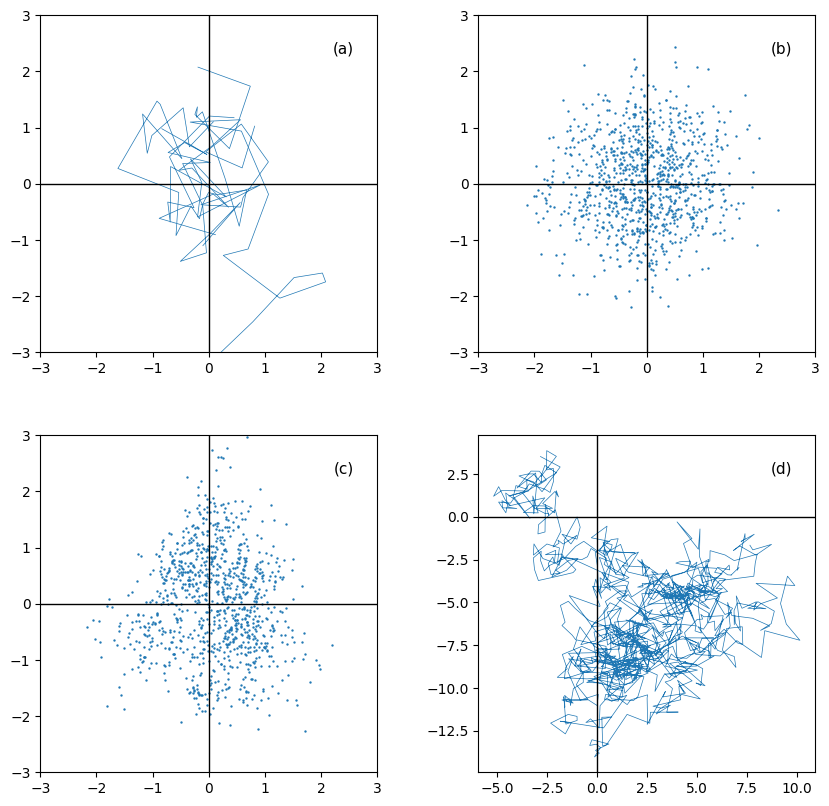

In [ ]:
VMC_He_plot(results.x)

**(a)** The first 20 moves of the particles without the thermalization moves. **(b)** Positions of one of the particles after 1000 moves with thermalization, ref. to the CM. **(c)** Positions of one of the particles after 1000 moves without thermalization, ref. to the CM. **(d)** Positions of one of the particles after 1000 moves with thermalization, ref. to the external origin.

# References

Rafael Pardo Guardiola. Monte carlo methods in quantum many-body theories. 1998. URL https://virtuale.unibo.it/mod/unibores/view.php?id=936307